# Overview

In [1]:
#File Name: Figure_6.ipynb
#Author: Matthias M. Fischer
#Last Revision: 17th March 2022
#Changelog: Initial Version.

#This file contains the complete commented source code
#for reproducing all plots from Figure 6 of the manuscript
#by Fischer and Blüthgen.

# Setup

In [1]:
# Library imports

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import numpy as np
import pandas as pd
import tqdm

In [2]:
# Convenience function:
# Return the maximum real part of all
# eigenvalues of a given matrix M

def lambdamax(M):
    return np.max(np.real(np.linalg.eigvals(M)))

In [3]:
# Return the coefficient matrix A describing
# the model where all NSCC compartments
# dedifferentiate

def A(K_C=1.0,                                        # CSC cycling rate
      K_N=1.0,                                        # NSCC cycling rate
      K_T=0.05,                                       # Dedifferentiation rate
      DeltaP = 0.18,                                  # Aggregate CSC fate choice parameter, Delta P := P_S - P_D
      D_C=0.05,                                       # CSC apoptosis rate
      D_N=0.05,                                       # NSCC apoptosis rate
      M=7):                                           # Number NSCC compartments
    
    beta = DeltaP*K_C - D_C                           # CSC compartment net growth rate
    iota = (1-DeltaP)*K_C                             # Influx rate compartment N_1, in multiples of C(t)
 
    A = np.zeros((M+1, M+1))                          # Initialise coefficient matrix A
    A[0,0] = beta                                     # A_{1,1} := beta
    A[1,0] = iota                                     # A_{2,1} := iota
    
    for i in range(1, M+1):                           # A_{1,i} := K_T for i in [2...M]
        A[0,i] = K_T
    
    for i in range(1, M):                             # A_{i,i} := -K_N - K_T - D_N for i in [1,M-1]
        A[i,i] = -K_N - K_T - D_N
    
    A[M,M] = -K_T - D_N                               # A_{M+1, M+1} := -K_T - D_N
    
    for i in range(2,M+1):                            # A_{i, i-1} := 2*K_N for i in [2, M]
        A[i,i-1] = 2*K_N
        
    return A

In [4]:
# For a given system parametrisation, quantify
# the interaction d_{X,Y}^{rel} between two
# treatments

def calculate_interaction_vector(params, h = 1e-6):
    e = [                                                                     # Unit vectors "in treatment direction"
         np.array([-1,0,0,0,0,0]),                                            # K_C is lowered during treatment
         np.array([0,-1,0,0,0,0]),                                            # K_N is lowered during treatment
         np.array([0,0,-1,0,0,0]),                                            # K_T is lowered during treatment
         np.array([0,0,0,-1,0,0]),                                            # DeltaP is lowered during treatment
         np.array([0,0,0,0,+1,0]),                                            # D_C is increased during treatment
         np.array([0,0,0,0,0,+1])                                             # D_N is increased during treatment
    ]
    
    S = []                                                                    # Result to be stored here

    M_baseline = params[-1]                                                   # Split parameter vector: M and rest,
    params_baseline = np.array(params[:-1])                                   # as we do not perturb integer M

    f = lambda p: lambdamax(A(*p, M=M_baseline))                              # Convenience function for evaluation
    
    for i in range(len(params_baseline)):                                     # For all parameter pairs:
        for j in range(len(params_baseline)):
            params_i = params_baseline + h*e[i]                               # Perturb i
            params_j = params_baseline + h*e[j]                               # Perturb j
            params_ij = params_baseline + h*e[i] + h*e[j]                     # Perturb both
            
            # Compute directional second derivative
            deriv = (f(params_ij)-f(params_i)-f(params_j)+f(params_baseline))/(h**2)
            # Compute relative interaction
            s = deriv * params_baseline[i] * params_baseline[j] / (f(params_baseline)**2)
            S.append(s)
    
    return S


In [5]:
# Return a set of randomly drawn system parameters

def draw_parameter_set(K_C_range = (0.5, 1.5),                           # The sampling ranges of all parameter values
                 K_N_range = (0.5, 1.5),
                 K_T_range = (0, 0.1),
                 DeltaP_range = (0.01, 0.35),
                 D_C_range = (0, 0.1),
                 D_N_range = (0, 0.1),
                 M_range = (3, 11)):
        
    K_C = np.random.uniform(K_C_range[0], K_C_range[1])                  # Sampling
    K_N = np.random.uniform(K_N_range[0], K_N_range[1])
    K_T = np.random.uniform(K_T_range[0], K_T_range[1])
    DeltaP = np.random.uniform(DeltaP_range[0], DeltaP_range[1])           
    M = int (np.random.uniform(M_range[0], M_range[1]))        
    D_C = np.random.uniform(D_C_range[0], D_C_range[1])
    D_N = np.random.uniform(D_N_range[0], D_N_range[1])

    return K_C, K_N, K_T, DeltaP, D_C, D_N, M

In [6]:
def simulate_cohort(n = 1000,                                           # Nb. of virtual patients to simulate
                    random_seed = 0):                                   # Random seed for reproducibility
    
    results = []                                                        # Results to be stored here
    np.random.seed(random_seed)                                         # Set random seed
    
    with tqdm.tqdm(total = n) as pbar:                                  # Progress bar
        while len(results) < n:                                         # As long as we need more patients:
            params = draw_parameter_set()                               # Draw new parameter vector
            K_C, K_N, K_T, DeltaP, D_C, D_N, M = params                 # Split it into individual variables
            
            lambda_baseline = lambdamax(A(*params))                     # Check if patient is eligible
            beta = DeltaP*K_C - D_C
            if 0.01 < lambda_baseline < 0.2 and beta > 0:            
                sensitivities = calculate_interaction_vector(params)    # If so, calculate parameter interactions
                results.append(sensitivities)
                pbar.update(1)
            
        
    return results    

# Figure 6B

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:17<00:00, 57.48it/s]


Text(38.199999999999996, 0.5, '$\\mathrm{Parameter \\; }y$')

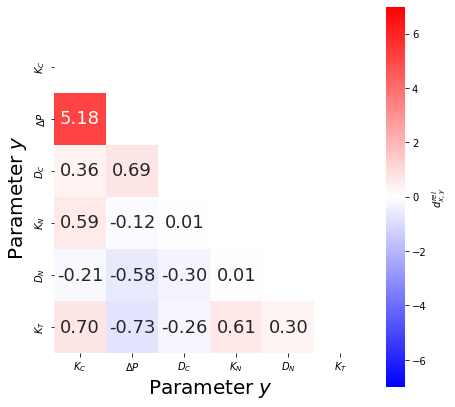

In [7]:
# Calculate pairwise parameter interactions from virtual cohort
interactions = simulate_cohort()

# Calculate the distribution means
means = list(map(np.mean, zip(*interactions)))

# Convert to a 6X6 matrix, 
# while also changing the order of the entries for the heatmap
hm_mean = np.zeros((6,6))
parameter_order = [0, 3, 4, 1, 5, 2]
for i in range(6):
    for j in range(6):
        hm_mean[i,j] = means[6*parameter_order[i]+parameter_order[j]]

# Proper annotation
hm_mean = pd.DataFrame(hm_mean)
hm_mean.columns = ["$K_C$", "$\Delta P$", "$D_C$", "$K_N$", "$D_N$", "$K_T$"]
hm_mean.index = ["$K_C$", "$\Delta P$", "$D_C$", "$K_N$", "$D_N$", "$K_T$"]

# Plot
plt.subplots(1,1,figsize=(7,7))
sns.heatmap(hm_mean.T, mask=np.triu(np.ones_like(hm_mean), k=0),
            cmap="bwr", center=0, vmin=-7, vmax=7, square=True,
            annot=True, annot_kws={'fontsize': 18}, fmt=".2f",
            cbar_kws = {'label': r'$d^{rel}_{x,y}$'})
plt.xlabel(r"$\mathrm{Parameter \; }y$", fontsize=20)
plt.ylabel(r"$\mathrm{Parameter \; }y$", fontsize=20)

# Figure 6C

[Text(1, 0, '$\\Delta P, K_C$'),
 Text(2, 0, '$\\Delta P, D_N$'),
 Text(3, 0, '$\\Delta P, K_T$')]

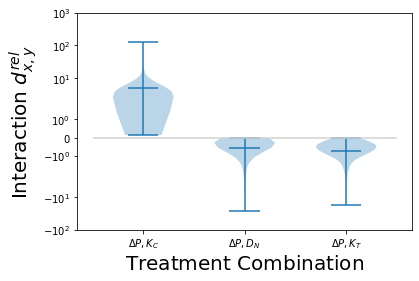

In [8]:
# Extract the three distributions we want to plot
# from the data of the previous section
d_rel_DeltaP_K_C = [l[3] for l in interactions]
d_rel_DeltaP_D_N = [l[23] for l in interactions]
d_rel_DeltaP_K_T = [l[20] for l in interactions]

# Plot distributions
fig, ax = plt.subplots()
plt.violinplot([d_rel_DeltaP_K_C, d_rel_DeltaP_D_N, d_rel_DeltaP_K_T],
             showmeans=True, widths=.6, vert=True)

# Aesthetics
plt.yscale("symlog")
plt.hlines([0], 0.5, 3.5, linestyle="-", color="lightgrey")
plt.ylim((-100, 1000))
plt.xlabel(r"$\mathrm{Treatment \ Combination}$", fontsize=20)
plt.ylabel(r"$\mathrm{Interaction \ } d^{rel}_{x,y}$", fontsize=20)
plt.xticks([1,2,3])
ax.set_xticklabels([r"$\Delta P, K_C$", r"$\Delta P, D_N$", r"$\Delta P, K_T$"])
